In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.decomposition import TruncatedSVD
from gensim.models import Word2Vec
import numpy as np

In [2]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
# Load the bug reports dataset
data = pd.read_excel("train.xlsx")
bug_reports = data['report']

# Tokenize bug reports and remove empty strings or tokens consisting only of spaces
stop_words = set(stopwords.words('english'))
tokenized_bug_reports = [[word.lower() for word in word_tokenize(report) if word.strip() and word.strip() not in stop_words] for report in bug_reports]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_bug_reports, vector_size=100, window=5, min_count=1, sg=1)





In [4]:
# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_bug_reports, vector_size=100, window=5, min_count=1, sg=1)

In [5]:
tokenized_bug_reports[:3]


[['``',
  'for',
  'event',
  'bookmarked',
  'projects',
  "''",
  'option',
  'sending',
  'notifications',
  'non-member',
  'bookmarked',
  'projects'],
 ['switch', 'using', 'full', 'l10n', 'id', "'s", 'urlbar'],
 ['consider', 'removing', 'hasicon', 'property', 'simplify', 'styling']]

In [6]:
# Save or load Word2Vec model (optional)
# word2vec_model.save("word2vec_model.bin")
# word2vec_model = Word2Vec.load("word2vec_model.bin")

In [7]:
# Get the word vectors for a specific word
test_word = "email"
word_vector = word2vec_model.wv[test_word]

# Print similar words to a given word
similar_words = word2vec_model.wv.most_similar(test_word)

print(similar_words)

[('mails', 0.9055989384651184), ('security', 0.9007429480552673), ('e-mail', 0.8876593112945557), ('sending', 0.8875666856765747), ('send', 0.8861684799194336), ('asynchronously', 0.8857014775276184), ('blockquote', 0.8837966918945312), ('ignoring', 0.8833033442497253), ('header', 0.877933144569397), ('individual', 0.8761353492736816)]


In [8]:
# Print the word embeddings
print("Word Embeddings:")
for word in word2vec_model.wv.index_to_key[:10]:
    print(f"{word}: {word2vec_model.wv[word]}")

Word Embeddings:
]: [-0.6069968   0.6593733   0.1057519   0.155515   -0.41801435 -0.5526118
  0.4756012   0.9945174  -0.20996909 -0.28483334  0.17468975 -0.21350573
 -0.17153755  0.45131359 -0.49547213 -0.3014303   0.2517686  -0.008357
 -0.6319362  -1.1900132   0.21800332  0.14718239  0.3597893  -0.10520825
  0.20818785 -0.13928896 -0.30934566  0.1969882  -0.7976388  -0.25176725
 -0.2732775   0.00651973  0.4464566  -0.5881717   0.16643874  0.34214857
  0.6189686  -0.51532155 -0.17159186 -0.40491366 -0.23962332  0.31840104
 -0.57413596 -0.1223287   0.25037622  0.04498958 -0.06790755  0.51227576
  0.1359615   0.4731313   0.03501588  0.02872819 -0.16662107  0.04303793
  0.27005756 -0.20261165  0.3533382  -0.41722652 -0.52050394  0.4203389
 -0.18876821 -0.20583105 -0.7481502  -0.31711552 -0.26687264  0.39894682
 -0.13405012  0.17222603 -0.21303271  0.30206847 -0.29327562  0.24214123
  0.04029576 -0.39173934  0.1703357   0.05850625  0.14709118  0.08342044
 -0.04807295  0.14614724 -0.1525408

In [9]:
# Derive document embeddings by averaging word embeddings
document_embeddings = np.array([np.mean([word2vec_model.wv[word] for word in report if word in word2vec_model.wv], axis=0) for report in tokenized_bug_reports])

print(document_embeddings.shape)

(14710, 100)


In [10]:
# trying DBSCAN ( density-based clustering algorithms )
from sklearn.cluster import DBSCAN

# Create DBSCAN object
dbscan = DBSCAN(eps=0.5, min_samples=20)  # Adjust parameters as needed

# Fit DBSCAN clustering on document embeddings
clusters = dbscan.fit_predict(document_embeddings)

# Print the number of clusters and number of noise points
n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise_ = list(clusters).count(-1)
print(f"Number of clusters: {n_clusters_}")
print(f"Number of noise points: {n_noise_}")


Number of clusters: 7
Number of noise points: 954


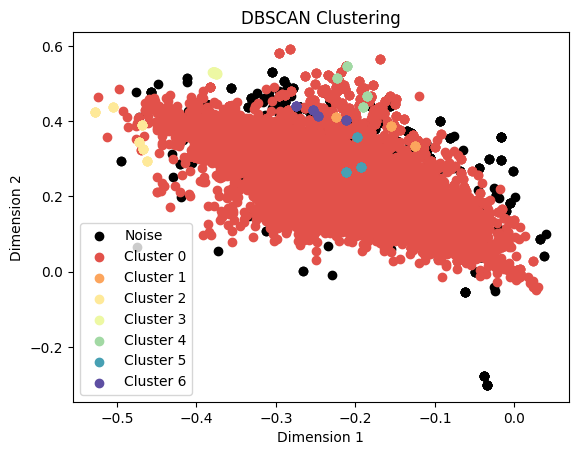

In [11]:
#  visualize clusters or perform further analysis
import matplotlib.pyplot as plt

# Visualize clusters
def visualize_clusters(embeddings, clusters):
    # Define colors for each cluster (including noise points)
    unique_clusters = np.unique(clusters)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_clusters))]

    # Plot data points with cluster assignments
    for cluster_id, color in zip(unique_clusters, colors):
        if cluster_id == -1:
            # Noise points (cluster_id = -1)
            plt.scatter(embeddings[clusters == cluster_id][:, 0], embeddings[clusters == cluster_id][:, 1], color='black', label='Noise')
        else:
            # Core and border points
            plt.scatter(embeddings[clusters == cluster_id][:, 0], embeddings[clusters == cluster_id][:, 1], color=color, label=f'Cluster {cluster_id}')

    # Add legend and labels
    plt.legend()
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('DBSCAN Clustering')

    # Show plot
    plt.show()

# Visualize clusters
visualize_clusters(document_embeddings, clusters)


In [ ]:
import csv

# Define the output CSV file path
output_csv_file = "cluster_assignments.csv"

# Write cluster assignments to CSV file
with open(output_csv_file, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['Cluster', 'Bug Report'])
    for cluster_label, reports in cluster_reports.items():
        if cluster_label == -1:
            cluster_name = 'Noise'
        else:
            cluster_name = f'Cluster {cluster_label}'
        for report in reports:
            writer.writerow([cluster_name, report])

print(f"Cluster assignments saved to '{output_csv_file}'")


Cluster assignments saved to 'cluster_assignments.csv'


In [12]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Compute Silhouette Score
silhouette_avg = silhouette_score(document_embeddings, clusters)
print(f"Silhouette Score: {silhouette_avg}")

# Compute Davies–Bouldin Index
db_index = davies_bouldin_score(document_embeddings, clusters)
print(f"Davies–Bouldin Index: {db_index}")


# The Silhouette Score being positive indicates that most samples are correctly clustered.
# A score around 0.217 suggests that clusters are at least somewhat well-separated.
# The Davies–Bouldin Index being around 1.368 indicates moderate separation between clusters.
# Lower values would indicate better clustering.

Silhouette Score: 0.21670055389404297
Davies–Bouldin Index: 1.3676055581081128
